In [1]:
import os
import zipfile

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

from google.colab import drive

np.random.seed(7)

## Pré processamento

### Acessando o data set

Fonte: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

In [2]:
url = 'https://raw.githubusercontent.com/ViniPilan/tcc-data/main/dataset/dataset.csv'
data = pd.read_csv(url)

data.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


### Análise exploratória

In [3]:
data['stroke'].value_counts().to_frame()

,stroke
0,4861
1,249


In [4]:
i = data.query('stroke == 0 and work_type != "children"').dropna(how='any', axis=0).index
n = data.query('stroke == 1').shape[0]+26

i_sampled = np.random.choice(i, n)

data = pd.concat([data.loc[i_sampled], data.query('stroke == 1')], axis=0).sort_index()

In [26]:
data['stroke'].value_counts(normalize=False).to_frame()

,stroke
0,275
1,249


In [6]:
quantitative = ['age', 'avg_glucose_level', 'bmi']
qualitative = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
               'work_type', 'Residence_type', 'smoking_status','stroke']

In [7]:
data[quantitative].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 524 entries, 0 to 5091
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                524 non-null    float64
 1   avg_glucose_level  524 non-null    float64
 2   bmi                484 non-null    float64
dtypes: float64(3)
memory usage: 16.4 KB


In [8]:
data[qualitative].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 524 entries, 0 to 5091
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          524 non-null    object
 1   hypertension    524 non-null    int64 
 2   heart_disease   524 non-null    int64 
 3   ever_married    524 non-null    object
 4   work_type       524 non-null    object
 5   Residence_type  524 non-null    object
 6   smoking_status  524 non-null    object
 7   stroke          524 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 36.8+ KB


In [9]:
for column in qualitative:
    display(data[column].value_counts(normalize=False).to_frame())

,gender
Female,306
Male,218


,hypertension
0,432
1,92


,heart_disease
0,465
1,59


,ever_married
Yes,420
No,104


,work_type
Private,329
Self-employed,116
Govt_job,75
children,2
Never_worked,2


,Residence_type
Urban,266
Rural,258


,smoking_status
never smoked,196
formerly smoked,129
Unknown,118
smokes,81


,stroke
0,275
1,249


In [10]:
data['gender'] = data['gender'].apply(lambda x:1 if x == 'Female' else 0)

data['ever_married'] = data['ever_married'].apply(lambda x:1 if x=='Yes' else 0)

data['Residence_type'] = data['Residence_type'].apply(lambda x:1 if x=='Urban' else 0)

data['work_type_private'] = data['work_type'].apply(lambda x:1 if x=='Private' else 0)
data['work_type_govt_job'] = data['work_type'].apply(lambda x:1 if x=='Govt_job' else 0)
data['work_type_self_emp'] = data['work_type'].apply(lambda x:1 if x=='Self-employed' else 0)

data['smoking_status_never'] = data['smoking_status'].apply(lambda x:1 if x=='never smoked' or x=='Unknown' else 0)
data['smoking_status_formerly'] = data['smoking_status'].apply(lambda x:1 if x=='formerly smoked' else 0)
data['smoking_status_smokes'] = data['smoking_status'].apply(lambda x:1 if x=='smokes' else 0)


data.rename({'gender':'gender_female', 'Residence_type':'Residence_type_urban'}, axis=1, inplace=True)
data.drop(['work_type', 'smoking_status', 'id'], axis=1, inplace=True)

qualitative = ['gender_female', 'hypertension', 'heart_disease', 'ever_married', 
               'work_type_private', 'work_type_govt_job', 'work_type_self_emp', 
               'Residence_type_urban', 'smoking_status_never',
               'smoking_status_formerly','smoking_status_smokes', 'stroke']

In [11]:
q1 = data['bmi'].quantile(0.25)
q3 = data['bmi'].quantile(0.75)

IQR = q3 - q1

limite_superior = q3 + 1.25*IQR
limite_inferior = q1 - 1.25*IQR

data['bmi'] = data['bmi'].apply(lambda x:limite_superior if x>limite_superior else x)
data['bmi'] = data['bmi'].apply(lambda x:limite_inferior if x<limite_inferior else x)

In [12]:
q1 = data['avg_glucose_level'].quantile(0.25)
q3 = data['avg_glucose_level'].quantile(0.75)

IQR = q3 - q1

limite_superior = q3 + 1.25*IQR
limite_inferior = q1 - 1.25*IQR

data['avg_glucose_level'] = data['avg_glucose_level'].apply(lambda x:limite_superior if x>limite_superior else x)
data['avg_glucose_level'] = data['avg_glucose_level'].apply(lambda x:limite_inferior if x<limite_inferior else x)

In [13]:
q1 = data['age'].quantile(0.25)
q3 = data['age'].quantile(0.75)

IQR = q3 - q1

limite_superior = q3 + 1.25*IQR
limite_inferior = q1 - 1.25*IQR

data['age'] = data['age'].apply(lambda x:limite_superior if x>limite_superior else x)
data['age'] = data['age'].apply(lambda x:limite_inferior if x<limite_inferior else x)

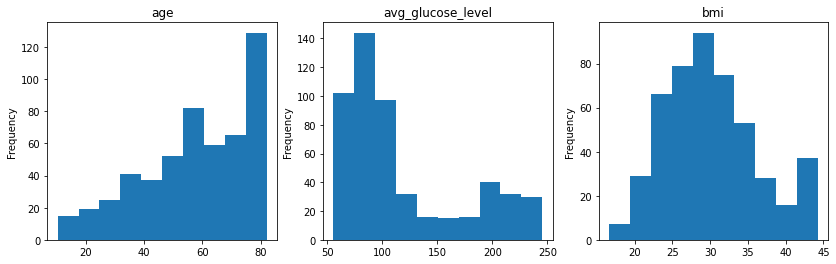

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(14,4))

i = 0

for column in quantitative:
    ax[i].set_title(column)
    data[column].plot(kind='hist', ax=ax[i])
    i += 1

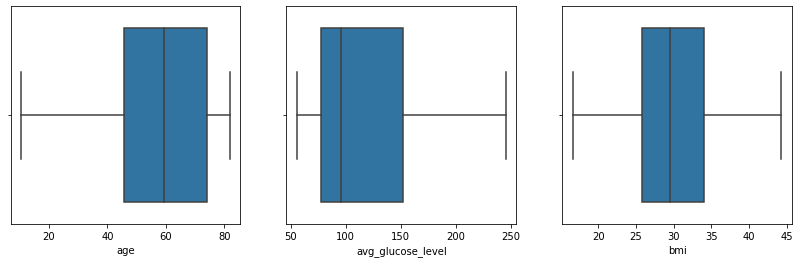

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(14,4))

i = 0

for column in quantitative:
    sns.boxplot(data=data, x=column, ax=ax[i])
    i += 1

In [16]:
for column in quantitative:
    print(shapiro(data[column]))

ShapiroResult(statistic=0.9345206618309021, pvalue=2.163694841784275e-14)
ShapiroResult(statistic=0.8349551558494568, pvalue=7.015059826736923e-23)
ShapiroResult(statistic=nan, pvalue=1.0)


In [17]:
scaler = MinMaxScaler()

data[quantitative] = scaler.fit_transform(data[quantitative])

In [18]:
median = data['bmi'].median()
data['bmi'] = data['bmi'].replace(np.nan, median)

# mean = data['bmi'].mean()
# data['bmi'] = data['bmi'].replace(np.nan, mean)

# data.dropna(how='any', axis=0, inplace=True)

# data.dropna(how='any', axis=1, inplace=True)

In [19]:
data.corr()['stroke'].sort_values().to_frame()

,stroke
smoking_status_never,-0.095215
work_type_private,-0.058012
gender_female,-0.034179
work_type_govt_job,-0.028801
bmi,0.004730
smoking_status_smokes,0.037100
Residence_type_urban,0.065732
smoking_status_formerly,0.077181
work_type_self_emp,0.090922
ever_married,0.195648


## Processamento - Processo de modelagem

In [20]:
X = data.drop('stroke', axis=1)
y = data['stroke']

### Treinamento e avaliação do algoritmo de Regressão Logística para o problema abordado

In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=7)

rights = [] #rights list
rights_positive = [] #positive rights list
rights_negative = [] #negative rights list
cms = [] #confusion matrix list
rocs = [] #AUC ROC list


for train_index, test_index in kf.split(X):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    
    model = LogisticRegression(random_state=7)
    model.fit(X_train, y_train)
    
    y_hat = model.predict(X_test)

    cm = confusion_matrix(y_true=y_test, y_pred=y_hat)
    cms.append(cm)
    
    right = (cm[1][1] + cm[0][0]) / (cm[1][0] + cm[1][1] + cm[0][0] + cm[0][1])
    rights.append(right)
    
    right_positive_rate = cm[1][1] / (cm[1][0] + cm[1][1])
    rights_positive.append(right_positive_rate)
    
    right_negative_rate = cm[0][0] / (cm[0][0] + cm[0][1])
    rights_negative.append(right_negative_rate)
    
    roc = roc_auc_score(y_true=y_test, y_score=model.predict_proba(X_test)[:, 1]) 
    rocs.append(roc)
    
rights = np.array(rights)    
rights_positive = np.array(rights_positive)
rights_negative = np.array(rights_negative)
rocs = np.array(rocs)

In [22]:
# Número de acertos
print('Porcentagem de acertos: %.2f%% +- %.2f%%' % (100*rights.mean(), 100*rights.std()))

# Número de acertos para casos positivos
print('Porcentagem de acertos especificamente para casos positivos: %.2f%% +- %.2f%%' % (100*rights_positive.mean(), 100*rights_positive.std()))

# Número de acertos para casos negativos
print('Porcentagem de acertos especificamente para casos negativos: %.2f%% +- %.2f%%' % (100*rights_negative.mean(), 100*rights_negative.std()))

# ROC
print('Média da área da curva ROC (max. 1): %.4f +- %.4f' % (rocs.mean(), rocs.std()))

Porcentagem de acertos: 73.86% +- 2.94%
Porcentagem de acertos especificamente para casos positivos: 76.65% +- 5.36%
Porcentagem de acertos especificamente para casos negativos: 71.95% +- 6.76%
Média da área da curva ROC (max. 1): 0.8032 +- 0.0378


### Treinamento e avaliação do algoritmo de Floresta aleatória para o problema abordado

In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=7)

rights = [] #rights list
rights_positive = [] #positive rights list
rights_negative = [] #negative rights list
cms = [] #confusion matrix list
rocs = [] #AUC ROC list


for train_index, test_index in kf.split(X):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    
    model = RandomForestClassifier(random_state=7)
    model.fit(X_train, y_train)
    
    y_hat = model.predict(X_test)

    cm = confusion_matrix(y_true=y_test, y_pred=y_hat)
    cms.append(cm)
    
    right = (cm[1][1] + cm[0][0]) / (cm[1][0] + cm[1][1] + cm[0][0] + cm[0][1])
    rights.append(right)
    
    right_positive_rate = cm[1][1] / (cm[1][0] + cm[1][1])
    rights_positive.append(right_positive_rate)
    
    right_negative_rate = cm[0][0] / (cm[0][0] + cm[0][1])
    rights_negative.append(right_negative_rate)
    
    roc = roc_auc_score(y_true=y_test, y_score=model.predict_proba(X_test)[:, 1]) 
    rocs.append(roc)
    
rights = np.array(rights)    
rights_positive = np.array(rights_positive)
rights_negative = np.array(rights_negative)
rocs = np.array(rocs)

In [24]:
# Número de acertos
print('Porcentagem de acertos: %.2f%% +- %.2f%%' % (100*rights.mean(), 100*rights.std()))

# Número de acertos para casos positivos
print('Porcentagem de acertos especificamente para casos positivos: %.2f%% +- %.2f%%' % (100*rights_positive.mean(), 100*rights_positive.std()))

# Número de acertos para casos negativos
print('Porcentagem de acertos especificamente para casos negativos: %.2f%% +- %.2f%%' % (100*rights_negative.mean(), 100*rights_negative.std()))

# ROC
print('Média da área da curva ROC (max. 1): %.4f +- %.4f' % (rocs.mean(), rocs.std()))

Porcentagem de acertos: 70.24% +- 4.08%
Porcentagem de acertos especificamente para casos positivos: 69.81% +- 6.10%
Porcentagem de acertos especificamente para casos negativos: 71.32% +- 7.39%
Média da área da curva ROC (max. 1): 0.7891 +- 0.0418


### Backup (com balanceamento 50/50)

#### Regressão logistica
- Porcentagem de acertos: 73.40% +- 4.63%
- Porcentagem de acertos especificamente para casos positivos: 76.14% +- 8.35%
- Porcentagem de acertos especificamente para casos negativos: 70.88% +- 7.70%
- Média da área da curva ROC (max. 1): 0.7946 +- 0.0450

#### Random Forest
- Porcentagem de acertos: 71.80% +- 2.64%
- Porcentagem de acertos especificamente para casos positivos: 75.87% +- 4.77%
- Porcentagem de acertos especificamente para casos negativos: 67.81% +- 6.66%
- Média da área da curva ROC (max. 1): 0.7796 +- 0.0280

### Backup (com balanceamento 255 não)

#### Regressão logistica
- Porcentagem de acertos: 73.48% +- 2.98%
- Porcentagem de acertos especificamente para casos positivos: 75.86% +- 5.78%
- Porcentagem de acertos especificamente para casos negativos: 71.95% +- 6.76%
- Média da área da curva ROC (max. 1): 0.8008 +- 0.0374

#### Random Forest
- Porcentagem de acertos: 70.82% +- 4.55%
- Porcentagem de acertos especificamente para casos positivos: 70.21% +- 5.77%
- Porcentagem de acertos especificamente para casos negativos: 72.02% +- 7.74%
- Média da área da curva ROC (max. 1): 0.7876 +- 0.0425


### Backup (com balanceamento 255 não e IQR em tudo)

#### Regressão Logística
- Porcentagem de acertos: 73.86% +- 2.94%
- Porcentagem de acertos especificamente para casos positivos: 76.65% +- 5.36%
- Porcentagem de acertos especificamente para casos negativos: 71.95% +- 6.76%
- Média da área da curva ROC (max. 1): 0.8032 +- 0.0378


#### Random Forest
- Porcentagem de acertos: 70.24% +- 4.08%
- Porcentagem de acertos especificamente para casos positivos: 69.81% +- 6.10%
- Porcentagem de acertos especificamente para casos negativos: 71.32% +- 7.39%
- Média da área da curva ROC (max. 1): 0.7891 +- 0.0418

